### importazione librerie e dataframe + funzioni

In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_excel("injury_data_dirty.xlsx")

In [3]:
#creo una funzione che mi sposti non nun verso sinistra
def sposta_sinistra(riga):
    riga_filtrata = riga.dropna().tolist()
    numero_nun = [np.nan] * (len(riga) - len(riga_filtrata))
    nuova_riga = riga_filtrata + numero_nun
    return nuova_riga


In [4]:
def scova_errori(colonna):
    errori = []
    for i in colonna:
        try:
            float(i)
        except ValueError:
            errori.append(i)
    return errori

In [5]:
df_injury = df.copy()
df_injury

,Player_Age,Player_Weight,Player_Height,Previous_Injuries,Training_Intensity,Recovery_Time,Likelihood_of_Injury,Unnamed: 7
0,24,66.251933,175.732429,1,0.457929,5,0,NaN
1,37,70.996271,174.58165,0,0.226522,6,1,NaN
2,32,80.093781,186.329618,0,0.61397,2,1,NaN
3,28,87.473271,175.50424,one,0.252858,4,1,NaN
4,ඞ,ඞ,ඞ,ඞ,ඞ,ඞ,ඞ,NaN
...,...,...,...,...,...,...,...,...
995,23,99.14791,165.290912,0,0.077857,3,1,NaN
996,23,75.799934,178.132281,1,0.955448,1,0,NaN
997,20,78.479061,173.823908,0,0.246961,1,1,NaN
998,24,66.915802,197.616889,1,0.859645,2,0,NaN


### pulizia del dataframe

#### pulizia da NuN e valori strani

In [6]:
#rinomino tutte le colonne con la stessa colonna ma in minuscolo
df_injury.rename(columns={"Player_Age": "player_age","Player_Weight":"player_weight","Player_Height":"player_height","Previous_Injuries":"previous_injuries", "Training_Intensity":"training_intensity", "Recovery_Time":"recovery_time", "Likelihood_of_Injury" : "likelihood_of_injury", "Unnamed: 7":"nan" }, inplace=True)


In [7]:
#sostituisco tutti gli ඞ con nan
df_injury = df_injury.replace("ඞ", np.nan)

In [8]:
#creo flag null per ogni colonna
df_injury["flag_na_player_age"] = df_injury["player_age"].isna()
df_injury["flag_na_player_weight"] = df_injury["player_weight"].isna()
df_injury["flag_na_player_height"] = df_injury["player_height"].isna()
df_injury["flag_na_previous_injuries"] = df_injury["previous_injuries"].isna()
df_injury["flag_na_training_intensity"] = df_injury["training_intensity"].isna()
df_injury["flag_na_recovery_time"] = df_injury["recovery_time"].isna()
df_injury["flag_na_likelihood_of_injury"] = df_injury["likelihood_of_injury"].isna()
df_injury["flag_na_nan"] = df_injury["nan"].isna()


In [9]:
#controllo che tutto sia andato a buon fine
df_injury

,player_age,player_weight,player_height,previous_injuries,training_intensity,recovery_time,likelihood_of_injury,nan,flag_na_player_age,flag_na_player_weight,flag_na_player_height,flag_na_previous_injuries,flag_na_training_intensity,flag_na_recovery_time,flag_na_likelihood_of_injury,flag_na_nan
0,24,66.251933,175.732429,1,0.457929,5,0,NaN,False,False,False,False,False,False,False,True
1,37,70.996271,174.581650,0,0.226522,6,1,NaN,False,False,False,False,False,False,False,True
2,32,80.093781,186.329618,0,0.613970,2,1,NaN,False,False,False,False,False,False,False,True
3,28,87.473271,175.504240,one,0.252858,4,1,NaN,False,False,False,False,False,False,False,True
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,23,99.147910,165.290912,0,0.077857,3,1,NaN,False,False,False,False,False,False,False,True
996,23,75.799934,178.132281,1,0.955448,1,0,NaN,False,False,False,False,False,False,False,True
997,20,78.479061,173.823908,0,0.246961,1,1,NaN,False,False,False,False,False,False,False,True
998,24,66.915802,197.616889,1,0.859645,2,0,NaN,False,False,False,False,False,False,False,True


In [10]:
df_injury["flag_na_nan"].value_counts()

True     999
False      1
Name: flag_na_nan, dtype: int64

In [11]:
df_injury["nan"].value_counts()

1.0    1
Name: nan, dtype: int64

In [12]:
#controllo quali file hanno nan per tutta la fila
df_injury.loc[df_injury["flag_na_player_age"] & df_injury["flag_na_player_weight"] & df_injury["flag_na_player_height"] ,:]

,player_age,player_weight,player_height,previous_injuries,training_intensity,recovery_time,likelihood_of_injury,nan,flag_na_player_age,flag_na_player_weight,flag_na_player_height,flag_na_previous_injuries,flag_na_training_intensity,flag_na_recovery_time,flag_na_likelihood_of_injury,flag_na_nan
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,True,True,True,True
113,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,True,True,True,True,True,False,True,True
223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,True,True,True,True
936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,True,True,True,True


In [13]:
#rimuovo le file inutili
df_injury = df_injury.drop(df_injury.index[[4,113,223,936]])

In [14]:
#controllo che abbia funzionato
df_injury.loc[df_injury["flag_na_player_age"] & df_injury["flag_na_player_weight"] & df_injury["flag_na_player_height"] ,:]

,player_age,player_weight,player_height,previous_injuries,training_intensity,recovery_time,likelihood_of_injury,nan,flag_na_player_age,flag_na_player_weight,flag_na_player_height,flag_na_previous_injuries,flag_na_training_intensity,flag_na_recovery_time,flag_na_likelihood_of_injury,flag_na_nan


In [15]:
#noto che a riga 832 è tutto spistato verso destra
df_injury.loc[df_injury["flag_na_player_age"]]

,player_age,player_weight,player_height,previous_injuries,training_intensity,recovery_time,likelihood_of_injury,nan,flag_na_player_age,flag_na_player_weight,flag_na_player_height,flag_na_previous_injuries,flag_na_training_intensity,flag_na_recovery_time,flag_na_likelihood_of_injury,flag_na_nan
154,NaN,60.656350,170.892962,1,0.787372,1,0,NaN,True,False,False,False,False,False,False,True
159,NaN,66.162222,187.792340,0,0.973800,4,0,NaN,True,False,False,False,False,False,False,True
173,NaN,77.425204,191.635088,1,0.817305,2,1,NaN,True,False,False,False,False,False,False,True
183,NaN,84.294825,182.300095,1,0.492535,3,1,NaN,True,False,False,False,False,False,False,True
207,NaN,80.010333,167.599397,1,0.297287,2,0,NaN,True,False,False,False,False,False,False,True
219,NaN,80.855035,178.056685,1,0.671271,6,1,NaN,True,False,False,False,False,False,False,True
826,NaN,69.166420,171.356089,1,0.662314,4,1,NaN,True,False,False,False,False,False,False,True
832,NaN,36.000000,66.462635,196.774629,0.000000,0.131687,1,1.0,True,False,False,False,False,False,False,False
848,NaN,78.041262,184.078768,1,0.720384,6,1,NaN,True,False,False,False,False,False,False,True
861,NaN,74.141068,182.848686,0,0.725372,3,0,NaN,True,False,False,False,False,False,False,True


In [16]:
#creo un db con l'errore e inizio a modificarlo
df_832 = df_injury.loc[832]
df_injury = df_injury.drop(index=832)
df_injury.shape


(995, 16)

In [17]:
df_832

player_age                             NaN
player_weight                         36.0
player_height                    66.462635
previous_injuries               196.774629
training_intensity                     0.0
recovery_time                     0.131687
likelihood_of_injury                     1
nan                                    1.0
flag_na_player_age                    True
flag_na_player_weight                False
flag_na_player_height                False
flag_na_previous_injuries            False
flag_na_training_intensity           False
flag_na_recovery_time                False
flag_na_likelihood_of_injury         False
flag_na_nan                          False
Name: 832, dtype: object

In [18]:
#verifico se si possono moltiplicare nan per creare una lista di piu nan
[np.nan] *2

[nan, nan]

In [19]:
#creo una funzione che mi sposti non nun verso sinistra
def sposta_sinistra(riga):
    riga_filtrata = riga.dropna().tolist()
    numero_nun = [np.nan] * (len(riga) - len(riga_filtrata))
    nuova_riga = riga_filtrata + numero_nun
    return nuova_riga


In [20]:
df_injury.tail(1)

,player_age,player_weight,player_height,previous_injuries,training_intensity,recovery_time,likelihood_of_injury,nan,flag_na_player_age,flag_na_player_weight,flag_na_player_height,flag_na_previous_injuries,flag_na_training_intensity,flag_na_recovery_time,flag_na_likelihood_of_injury,flag_na_nan
999,36,71.847352,177.171535,0,0.16881,1,0,NaN,False,False,False,False,False,False,False,True


In [21]:
#aggiungo la riga modificata al dataferame
df_injury.loc[1000] = sposta_sinistra(df_832)

In [22]:
#controllo di avere aggiunt ocorrettamente e resetto l'index
df_injury.reset_index(inplace=True, drop=True)
df_injury.tail(1)

,player_age,player_weight,player_height,previous_injuries,training_intensity,recovery_time,likelihood_of_injury,nan,flag_na_player_age,flag_na_player_weight,flag_na_player_height,flag_na_previous_injuries,flag_na_training_intensity,flag_na_recovery_time,flag_na_likelihood_of_injury,flag_na_nan
995,36.0,66.462635,196.774629,0.0,0.131687,1,1.0,True,False,False,False,False,False,False,False,NaN


In [23]:
#questi sono gli na rimasti su player age vedrò poi come sostituirli
df_injury.loc[df_injury["flag_na_player_age"]]

,player_age,player_weight,player_height,previous_injuries,training_intensity,recovery_time,likelihood_of_injury,nan,flag_na_player_age,flag_na_player_weight,flag_na_player_height,flag_na_previous_injuries,flag_na_training_intensity,flag_na_recovery_time,flag_na_likelihood_of_injury,flag_na_nan
152,NaN,60.656350,170.892962,1,0.787372,1,0,NaN,True,False,False,False,False,False,False,True
157,NaN,66.162222,187.792340,0,0.973800,4,0,NaN,True,False,False,False,False,False,False,True
171,NaN,77.425204,191.635088,1,0.817305,2,1,NaN,True,False,False,False,False,False,False,True
181,NaN,84.294825,182.300095,1,0.492535,3,1,NaN,True,False,False,False,False,False,False,True
205,NaN,80.010333,167.599397,1,0.297287,2,0,NaN,True,False,False,False,False,False,False,True
217,NaN,80.855035,178.056685,1,0.671271,6,1,NaN,True,False,False,False,False,False,False,True
823,NaN,69.166420,171.356089,1,0.662314,4,1,NaN,True,False,False,False,False,False,False,True
844,NaN,78.041262,184.078768,1,0.720384,6,1,NaN,True,False,False,False,False,False,False,True
857,NaN,74.141068,182.848686,0,0.725372,3,0,NaN,True,False,False,False,False,False,False,True


In [24]:
df_injury.loc[df_injury["flag_na_player_weight"]]

,player_age,player_weight,player_height,previous_injuries,training_intensity,recovery_time,likelihood_of_injury,nan,flag_na_player_age,flag_na_player_weight,flag_na_player_height,flag_na_previous_injuries,flag_na_training_intensity,flag_na_recovery_time,flag_na_likelihood_of_injury,flag_na_nan
126,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,True,True,True,True,True,True


In [25]:
df_injury.loc[[127,126,125]]

,player_age,player_weight,player_height,previous_injuries,training_intensity,recovery_time,likelihood_of_injury,nan,flag_na_player_age,flag_na_player_weight,flag_na_player_height,flag_na_previous_injuries,flag_na_training_intensity,flag_na_recovery_time,flag_na_likelihood_of_injury,flag_na_nan
127,32,74.690417,188.342327,1,0.757283,1,0,NaN,False,False,False,False,False,False,False,True
126,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,True,True,True,True,True,True
125,26,69.550778,186.674608,0,0.170936,4,1,NaN,False,False,False,False,False,False,False,True


In [26]:
df_injury = df_injury.drop(index=126)

In [27]:
df_injury.loc[df_injury["flag_na_player_height"]]

,player_age,player_weight,player_height,previous_injuries,training_intensity,recovery_time,likelihood_of_injury,nan,flag_na_player_age,flag_na_player_weight,flag_na_player_height,flag_na_previous_injuries,flag_na_training_intensity,flag_na_recovery_time,flag_na_likelihood_of_injury,flag_na_nan


In [28]:
df_injury.loc[df_injury["flag_na_previous_injuries"]]

,player_age,player_weight,player_height,previous_injuries,training_intensity,recovery_time,likelihood_of_injury,nan,flag_na_player_age,flag_na_player_weight,flag_na_player_height,flag_na_previous_injuries,flag_na_training_intensity,flag_na_recovery_time,flag_na_likelihood_of_injury,flag_na_nan
754,34,84.893694,173.602355,NaN,0.138125,1,0,NaN,False,False,False,True,False,False,False,True
760,19,82.621984,171.315590,NaN,0.760006,1,1,NaN,False,False,False,True,False,False,False,True
761,30,74.701095,173.147938,NaN,0.312598,5,0,NaN,False,False,False,True,False,False,False,True
769,28,65.058938,185.410568,NaN,0.765859,3,0,NaN,False,False,False,True,False,False,False,True


In [29]:
df_injury.loc[df_injury["flag_na_training_intensity"]]

,player_age,player_weight,player_height,previous_injuries,training_intensity,recovery_time,likelihood_of_injury,nan,flag_na_player_age,flag_na_player_weight,flag_na_player_height,flag_na_previous_injuries,flag_na_training_intensity,flag_na_recovery_time,flag_na_likelihood_of_injury,flag_na_nan


In [30]:
df_injury.loc[df_injury["flag_na_recovery_time"]]

,player_age,player_weight,player_height,previous_injuries,training_intensity,recovery_time,likelihood_of_injury,nan,flag_na_player_age,flag_na_player_weight,flag_na_player_height,flag_na_previous_injuries,flag_na_training_intensity,flag_na_recovery_time,flag_na_likelihood_of_injury,flag_na_nan


In [31]:
df_injury.loc[df_injury["flag_na_likelihood_of_injury"]]

,player_age,player_weight,player_height,previous_injuries,training_intensity,recovery_time,likelihood_of_injury,nan,flag_na_player_age,flag_na_player_weight,flag_na_player_height,flag_na_previous_injuries,flag_na_training_intensity,flag_na_recovery_time,flag_na_likelihood_of_injury,flag_na_nan


In [32]:
df_injury["nan"].value_counts()


True    1
Name: nan, dtype: int64

In [33]:
#rimuovo le colonne che non servono piu perche pulite e sistemo quelle rimaste
df_injury = df_injury.drop(["nan", "flag_na_nan","flag_na_likelihood_of_injury","flag_na_recovery_time","flag_na_training_intensity","flag_na_player_height","flag_na_player_weight",], axis=1)

df_injury["flag_na_player_age"] = df_injury["player_age"].isna()
df_injury["flag_na_previous_injuries"] = df_injury["previous_injuries"].isna()

In [34]:
df_injury

,player_age,player_weight,player_height,previous_injuries,training_intensity,recovery_time,likelihood_of_injury,flag_na_player_age,flag_na_previous_injuries
0,24,66.251933,175.732429,1,0.457929,5,0,False,False
1,37,70.996271,174.581650,0,0.226522,6,1,False,False
2,32,80.093781,186.329618,0,0.613970,2,1,False,False
3,28,87.473271,175.504240,one,0.252858,4,1,False,False
4,38,75.820549,206.631824,1,0.359209,4,0,False,False
...,...,...,...,...,...,...,...,...,...
991,23,75.799934,178.132281,1,0.955448,1,0,False,False
992,20,78.479061,173.823908,0,0.246961,1,1,False,False
993,24,66.915802,197.616889,1,0.859645,2,0,False,False
994,36,71.847352,177.171535,0,0.168810,1,0,False,False


In [35]:
df_injury.loc[df_injury["flag_na_previous_injuries"]]

,player_age,player_weight,player_height,previous_injuries,training_intensity,recovery_time,likelihood_of_injury,flag_na_player_age,flag_na_previous_injuries
754,34,84.893694,173.602355,NaN,0.138125,1,0,False,True
760,19,82.621984,171.315590,NaN,0.760006,1,1,False,True
761,30,74.701095,173.147938,NaN,0.312598,5,0,False,True
769,28,65.058938,185.410568,NaN,0.765859,3,0,False,True


In [36]:
df_injury.loc[df_injury["flag_na_player_age"]]

,player_age,player_weight,player_height,previous_injuries,training_intensity,recovery_time,likelihood_of_injury,flag_na_player_age,flag_na_previous_injuries
152,NaN,60.656350,170.892962,1,0.787372,1,0,True,False
157,NaN,66.162222,187.792340,0,0.973800,4,0,True,False
171,NaN,77.425204,191.635088,1,0.817305,2,1,True,False
181,NaN,84.294825,182.300095,1,0.492535,3,1,True,False
205,NaN,80.010333,167.599397,1,0.297287,2,0,True,False
217,NaN,80.855035,178.056685,1,0.671271,6,1,True,False
823,NaN,69.166420,171.356089,1,0.662314,4,1,True,False
844,NaN,78.041262,184.078768,1,0.720384,6,1,True,False
857,NaN,74.141068,182.848686,0,0.725372,3,0,True,False


#### pulizia errori bast

In [37]:
df_injury

,player_age,player_weight,player_height,previous_injuries,training_intensity,recovery_time,likelihood_of_injury,flag_na_player_age,flag_na_previous_injuries
0,24,66.251933,175.732429,1,0.457929,5,0,False,False
1,37,70.996271,174.581650,0,0.226522,6,1,False,False
2,32,80.093781,186.329618,0,0.613970,2,1,False,False
3,28,87.473271,175.504240,one,0.252858,4,1,False,False
4,38,75.820549,206.631824,1,0.359209,4,0,False,False
...,...,...,...,...,...,...,...,...,...
991,23,75.799934,178.132281,1,0.955448,1,0,False,False
992,20,78.479061,173.823908,0,0.246961,1,1,False,False
993,24,66.915802,197.616889,1,0.859645,2,0,False,False
994,36,71.847352,177.171535,0,0.168810,1,0,False,False


In [38]:
#problema con apostrofi ed i
df_injury["player_age"].value_counts().to_dict()

{18: 60,
 22: 56,
 20: 56,
 34: 53,
 36: 50,
 25: 47,
 38: 46,
 29: 46,
 39: 45,
 19: 45,
 32: 44,
 30: 44,
 33: 43,
 23: 43,
 24: 42,
 21: 42,
 26: 40,
 37: 37,
 31: 36,
 27: 35,
 35: 35,
 28: 34,
 "32'": 2,
 "36'": 1,
 "37'": 1,
 "21'": 1,
 '32ì': 1,
 "31'": 1}

In [39]:
def scova_errori(colonna):
    errori = []
    for i in colonna:
        try:
            float(i)
        except ValueError:
            errori.append(i)
    return errori

In [40]:
scova_errori(df_injury["player_age"])

["36'", "32'", "37'", "21'", "32'", '32ì', "31'"]

In [41]:
df_injury['player_age'] = df_injury['player_age'].replace({"'": '', "ì": ''}, regex=True)
df_injury['player_age'] = df_injury['player_age'].astype(float)

In [42]:
df_injury["player_age"].value_counts().to_dict()

{18.0: 60,
 22.0: 56,
 20.0: 56,
 34.0: 53,
 36.0: 51,
 32.0: 47,
 25.0: 47,
 29.0: 46,
 38.0: 46,
 39.0: 45,
 19.0: 45,
 30.0: 44,
 23.0: 43,
 21.0: 43,
 33.0: 43,
 24.0: 42,
 26.0: 40,
 37.0: 38,
 31.0: 37,
 27.0: 35,
 35.0: 35,
 28.0: 34}

---

In [43]:
#nessun problema
df_injury["player_weight"].value_counts().to_dict()

{66.251932862553: 1,
 65.850409322173: 1,
 76.085426760284: 1,
 79.626263353811: 1,
 96.178559496259: 1,
 63.273967431387: 1,
 62.665318987199: 1,
 81.949979007769: 1,
 94.465428375148: 1,
 72.395014380613: 1,
 92.268338422188: 1,
 75.964337187935: 1,
 68.191127179609: 1,
 65.093076113623: 1,
 81.294135848868: 1,
 75.81276842767: 1,
 59.657013736155: 1,
 90.834650253841: 1,
 71.932196071286: 1,
 88.140094746439: 1,
 62.854565102736: 1,
 69.660908986832: 1,
 60.928559737851: 1,
 75.729967559734: 1,
 82.800781797166: 1,
 75.751870876062: 1,
 87.270500599702: 1,
 67.508207593709: 1,
 77.253427536891: 1,
 69.725306763861: 1,
 85.310629139881: 1,
 82.013730648392: 1,
 68.781816994936: 1,
 75.334587709923: 1,
 80.243627472529: 1,
 67.650895855222: 1,
 71.45892358552: 1,
 79.535378337452: 1,
 87.245844376261: 1,
 91.23396562299: 1,
 59.630520399737: 1,
 77.677512243645: 1,
 89.594936033835: 1,
 58.146890612381: 1,
 78.143834940548: 1,
 74.979162025798: 1,
 79.145418143798: 1,
 67.276959746735

In [44]:
scova_errori(df_injury["player_weight"])

[]

---

In [45]:
#nessun problema
df_injury["player_height"].value_counts().to_dict()

{175.73242883118: 1,
 170.47821193261: 1,
 166.74490088318: 1,
 174.49278804304: 1,
 169.73780361255: 1,
 176.33768460682: 1,
 184.43880230217: 1,
 180.11141563049: 1,
 187.09641290506: 1,
 192.65629535586: 1,
 176.31204063322: 1,
 175.21432757984: 1,
 189.57727653662: 1,
 190.3704728874: 1,
 187.40590868103: 1,
 184.22655065502: 1,
 183.76574015139: 1,
 181.09470604047: 1,
 190.5252894135: 1,
 174.27127910462: 1,
 163.3338970885: 1,
 186.9023680038: 1,
 154.41631616743: 1,
 172.68486596104: 1,
 169.76804488682: 1,
 169.70065329094: 1,
 172.50968529045: 1,
 192.17373569752: 1,
 188.20555419006: 1,
 177.48269318007: 1,
 184.09028053743: 1,
 145.28570108062: 1,
 176.39108580575: 1,
 175.94589992386: 1,
 166.55885529637: 1,
 163.96739533184: 1,
 182.47511916576: 1,
 181.50405438176: 1,
 181.00520094508: 1,
 185.8773165248: 1,
 191.91958856117: 1,
 174.07733469175: 1,
 184.06477477238: 1,
 164.20384492594: 1,
 193.78709746263: 1,
 167.55168761782: 1,
 172.8991888096: 1,
 174.02290486267: 1

In [46]:
scova_errori(df_injury["player_height"])

[]

---

##### attenzione qui ho creato ulteriori nun

In [47]:
# 1 scritto "one", 0 scritto "zero", #
df_injury["previous_injuries"].value_counts().to_dict()

{1: 507, 0: 470, 'one': 5, 'zero': 5, '#': 4}

In [48]:
scova_errori(df_injury["previous_injuries"])

['one',
 '#',
 'one',
 'one',
 'zero',
 'zero',
 'zero',
 '#',
 '#',
 'zero',
 'one',
 '#',
 'zero',
 'one']

In [49]:
df_injury['previous_injuries'] = df_injury['previous_injuries'].replace({"one": 1, "zero": 0, "#": np.nan}, regex=True)

In [50]:
df_injury["previous_injuries"].value_counts().to_dict()

{1.0: 512, 0.0: 475}

---

In [51]:
#nessun problema
df_injury["training_intensity"].value_counts().to_dict()

{0.45792899443403: 1,
 0.57028693873139: 1,
 0.90704196041502: 1,
 0.99153277582739: 1,
 0.20831539000852: 1,
 0.35543933736406: 1,
 0.66921902992487: 1,
 0.48380253986065: 1,
 0.41838953337833: 1,
 0.35781124933559: 1,
 0.59378063194345: 1,
 0.57559342864008: 1,
 0.16145783406424: 1,
 0.47173983751844: 1,
 0.55347177620985: 1,
 0.21010719291235: 1,
 0.28722120920515: 1,
 0.74227139225229: 1,
 0.02519909482107: 1,
 0.35483185554316: 1,
 0.78021264853563: 1,
 0.5638929210554: 1,
 0.26116243251086: 1,
 0.69495311934305: 1,
 0.56739094415607: 1,
 0.79624360945639: 1,
 0.73502518618982: 1,
 0.61010792203623: 1,
 0.48817767531081: 1,
 0.13318212566752: 1,
 0.87960149671176: 1,
 0.94927310624562: 1,
 0.15873676337431: 1,
 0.13300979890733: 1,
 0.24067051475715: 1,
 0.87430733413708: 1,
 0.83062276043179: 1,
 0.22465739764177: 1,
 0.39933258019922: 1,
 0.40967286929252: 1,
 0.97822066852656: 1,
 0.1808919013789: 1,
 0.79915797110478: 1,
 0.33419271417311: 1,
 0.73087034577616: 1,
 0.420011004

In [52]:
scova_errori(df_injury["training_intensity"])

[]

-------

In [53]:
#nessun problema
df_injury["training_intensity"].value_counts().to_dict()

{0.45792899443403: 1,
 0.57028693873139: 1,
 0.90704196041502: 1,
 0.99153277582739: 1,
 0.20831539000852: 1,
 0.35543933736406: 1,
 0.66921902992487: 1,
 0.48380253986065: 1,
 0.41838953337833: 1,
 0.35781124933559: 1,
 0.59378063194345: 1,
 0.57559342864008: 1,
 0.16145783406424: 1,
 0.47173983751844: 1,
 0.55347177620985: 1,
 0.21010719291235: 1,
 0.28722120920515: 1,
 0.74227139225229: 1,
 0.02519909482107: 1,
 0.35483185554316: 1,
 0.78021264853563: 1,
 0.5638929210554: 1,
 0.26116243251086: 1,
 0.69495311934305: 1,
 0.56739094415607: 1,
 0.79624360945639: 1,
 0.73502518618982: 1,
 0.61010792203623: 1,
 0.48817767531081: 1,
 0.13318212566752: 1,
 0.87960149671176: 1,
 0.94927310624562: 1,
 0.15873676337431: 1,
 0.13300979890733: 1,
 0.24067051475715: 1,
 0.87430733413708: 1,
 0.83062276043179: 1,
 0.22465739764177: 1,
 0.39933258019922: 1,
 0.40967286929252: 1,
 0.97822066852656: 1,
 0.1808919013789: 1,
 0.79915797110478: 1,
 0.33419271417311: 1,
 0.73087034577616: 1,
 0.420011004

In [54]:
scova_errori(df_injury["training_intensity"])

[]

---

In [55]:
#nessun problema
df_injury["recovery_time"].value_counts().to_dict()

{2: 196, 4: 180, 5: 166, 1: 160, 6: 156, 3: 137}

In [56]:
scova_errori(df_injury["recovery_time"])

[]

---

In [57]:
#solito problema 0 scritto zero e qua cè un meno 1
df_injury["likelihood_of_injury"].value_counts().to_dict()

{0: 496, 1: 496, 'zero': 2, -1: 1}

In [58]:
scova_errori(df_injury["likelihood_of_injury"])

['zero', 'zero']

In [59]:
df_injury["likelihood_of_injury"] = df_injury["likelihood_of_injury"].replace({"zero": 0, -1: 1}, regex=True)

In [60]:
df_injury["likelihood_of_injury"].value_counts().to_dict()

{0.0: 498, 1.0: 497}

---

### nan rimasi

In [61]:
df_injury["flag_na_player_age"] = df_injury["player_age"].isna()
df_injury["flag_na_previous_injuries"] = df_injury["previous_injuries"].isna()

In [62]:
df_injury.loc[df_injury["flag_na_player_age"]]

,player_age,player_weight,player_height,previous_injuries,training_intensity,recovery_time,likelihood_of_injury,flag_na_player_age,flag_na_previous_injuries
152,NaN,60.656350,170.892962,1.0,0.787372,1,0.0,True,False
157,NaN,66.162222,187.792340,0.0,0.973800,4,0.0,True,False
171,NaN,77.425204,191.635088,1.0,0.817305,2,1.0,True,False
181,NaN,84.294825,182.300095,1.0,0.492535,3,1.0,True,False
205,NaN,80.010333,167.599397,1.0,0.297287,2,0.0,True,False
217,NaN,80.855035,178.056685,1.0,0.671271,6,1.0,True,False
823,NaN,69.166420,171.356089,1.0,0.662314,4,1.0,True,False
844,NaN,78.041262,184.078768,1.0,0.720384,6,1.0,True,False
857,NaN,74.141068,182.848686,0.0,0.725372,3,0.0,True,False


In [63]:
df_injury.loc[df_injury["flag_na_previous_injuries"]]

,player_age,player_weight,player_height,previous_injuries,training_intensity,recovery_time,likelihood_of_injury,flag_na_player_age,flag_na_previous_injuries
5,24.0,70.126050,177.044588,NaN,0.823552,2,0.0,False,True
189,22.0,81.186620,180.301616,NaN,0.760161,1,1.0,False,True
190,18.0,87.862686,177.434121,NaN,0.153900,2,1.0,False,True
196,23.0,83.184847,202.908839,NaN,0.056680,6,0.0,False,True
754,34.0,84.893694,173.602355,NaN,0.138125,1,0.0,False,True
760,19.0,82.621984,171.315590,NaN,0.760006,1,1.0,False,True
761,30.0,74.701095,173.147938,NaN,0.312598,5,0.0,False,True
769,28.0,65.058938,185.410568,NaN,0.765859,3,0.0,False,True


### duplicati

In [64]:
#controllo se vi sono intere righe duplicate
df_injury["flag_dupli"] = df_injury.duplicated()

In [65]:
df_injury.loc[df_injury["flag_dupli"]]

,player_age,player_weight,player_height,previous_injuries,training_intensity,recovery_time,likelihood_of_injury,flag_na_player_age,flag_na_previous_injuries,flag_dupli


In [66]:
df_injury.reset_index(inplace=True, drop=False)

### creazione chiave univoca

In [67]:
#creazione chiave univoca
chiave_univoca = []
for i in df_injury["index"]:
    s = "player_id_" + str(i)
    chiave_univoca.append(s)

In [68]:
df_injury["player_id"] = chiave_univoca

In [69]:
df_injury.drop("index", axis=1)

,player_age,player_weight,player_height,previous_injuries,training_intensity,recovery_time,likelihood_of_injury,flag_na_player_age,flag_na_previous_injuries,flag_dupli,player_id
0,24.0,66.251933,175.732429,1.0,0.457929,5,0.0,False,False,False,player_id_0
1,37.0,70.996271,174.581650,0.0,0.226522,6,1.0,False,False,False,player_id_1
2,32.0,80.093781,186.329618,0.0,0.613970,2,1.0,False,False,False,player_id_2
3,28.0,87.473271,175.504240,1.0,0.252858,4,1.0,False,False,False,player_id_3
4,38.0,75.820549,206.631824,1.0,0.359209,4,0.0,False,False,False,player_id_4
...,...,...,...,...,...,...,...,...,...,...,...
990,23.0,75.799934,178.132281,1.0,0.955448,1,0.0,False,False,False,player_id_991
991,20.0,78.479061,173.823908,0.0,0.246961,1,1.0,False,False,False,player_id_992
992,24.0,66.915802,197.616889,1.0,0.859645,2,0.0,False,False,False,player_id_993
993,36.0,71.847352,177.171535,0.0,0.168810,1,0.0,False,False,False,player_id_994


In [70]:
df_injury["flag_cu"] = df_injury["player_id"].duplicated()

In [71]:
df_injury.loc[df_injury["flag_cu"]]

,index,player_age,player_weight,player_height,previous_injuries,training_intensity,recovery_time,likelihood_of_injury,flag_na_player_age,flag_na_previous_injuries,flag_dupli,player_id,flag_cu


## analisi

In [72]:
#creo un nuovo df dove non sono presenti nun
df_nonun = df_injury.dropna()
df_nonun

,index,player_age,player_weight,player_height,previous_injuries,training_intensity,recovery_time,likelihood_of_injury,flag_na_player_age,flag_na_previous_injuries,flag_dupli,player_id,flag_cu
0,0,24.0,66.251933,175.732429,1.0,0.457929,5,0.0,False,False,False,player_id_0,False
1,1,37.0,70.996271,174.581650,0.0,0.226522,6,1.0,False,False,False,player_id_1,False
2,2,32.0,80.093781,186.329618,0.0,0.613970,2,1.0,False,False,False,player_id_2,False
3,3,28.0,87.473271,175.504240,1.0,0.252858,4,1.0,False,False,False,player_id_3,False
4,4,38.0,75.820549,206.631824,1.0,0.359209,4,0.0,False,False,False,player_id_4,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,991,23.0,75.799934,178.132281,1.0,0.955448,1,0.0,False,False,False,player_id_991,False
991,992,20.0,78.479061,173.823908,0.0,0.246961,1,1.0,False,False,False,player_id_992,False
992,993,24.0,66.915802,197.616889,1.0,0.859645,2,0.0,False,False,False,player_id_993,False
993,994,36.0,71.847352,177.171535,0.0,0.168810,1,0.0,False,False,False,player_id_994,False


C:\Users\lucam\AppData\Local\Temp\ipykernel_20760\4195946563.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_nonun[["player_age","player_weight","player_height","previous_injuries","training_intensity","recovery_time","likelihood_of_injury"]].corr(),annot=True)


<Axes: >

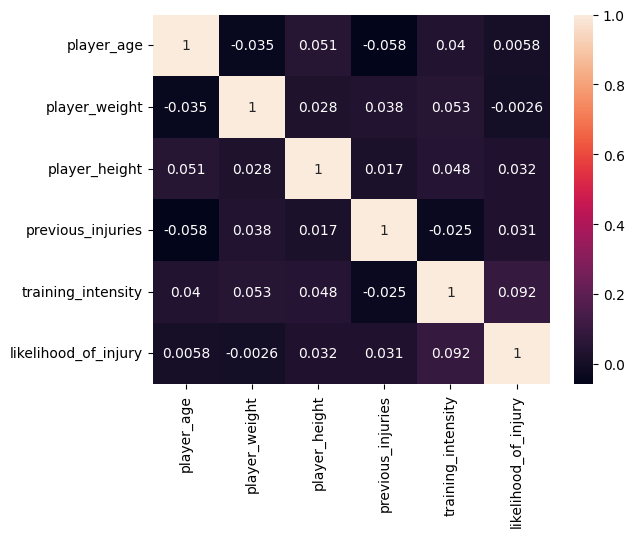

In [73]:
#correlation heatmap
# fig, ax = plt.subplots(figsize=(20, 12))
# sns.heatmap(df_injury[["player_age","player_weight","player_height","previous_injuries","training_intensity","recovery_time","likelihood_of_injury"]].corr(), ax=ax, annot=True)

sns.heatmap(df_nonun[["player_age","player_weight","player_height","previous_injuries","training_intensity","recovery_time","likelihood_of_injury"]].corr(),annot=True)

### analisi univariate

#### player age

<Axes: >

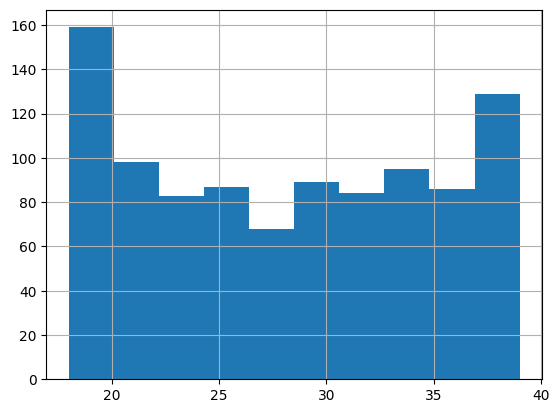

In [74]:
df_nonun["player_age"].hist()

In [75]:
print(df_nonun["player_age"].max())
print(df_nonun["player_age"].min())

39.0
18.0


#### training_intensity

(array([103.,  99.,  95., 105.,  97., 109., 106.,  69., 107.,  88.]),
 array([3.07188454e-05, 9.98025859e-02, 1.99574453e-01, 2.99346320e-01,
        3.99118187e-01, 4.98890054e-01, 5.98661921e-01, 6.98433788e-01,
        7.98205655e-01, 8.97977522e-01, 9.97749389e-01]),
 <BarContainer object of 10 artists>)

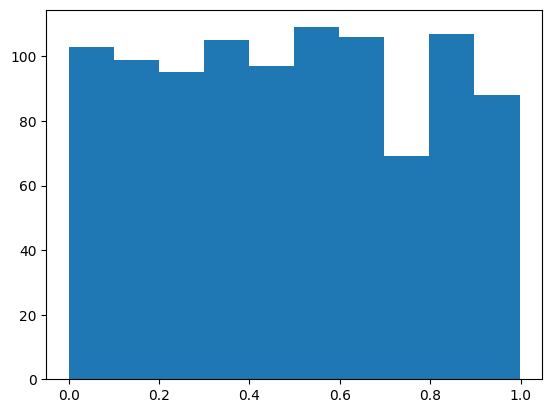

In [76]:
plt.hist(df_nonun["training_intensity"])

In [77]:
raggruppamento = [0, 0.25, 0.50, 0.75, 1]
tipologie = ["leggero", "medio_leggero", "medio_duro", "duro"]
df_nonun["categoria_allenamento"] = pd.cut(df_nonun['training_intensity'], bins= raggruppamento, labels=tipologie, include_lowest=True)

C:\Users\lucam\AppData\Local\Temp\ipykernel_20760\1594656603.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nonun["categoria_allenamento"] = pd.cut(df_nonun['training_intensity'], bins= raggruppamento, labels=tipologie, include_lowest=True)


(array([247.,   0.,   0., 253.,   0.,   0., 250.,   0.,   0., 228.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

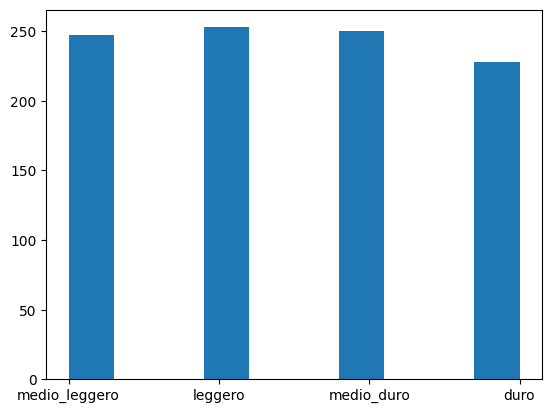

In [78]:
plt.hist(df_nonun["categoria_allenamento"])

#### player height

<Axes: >

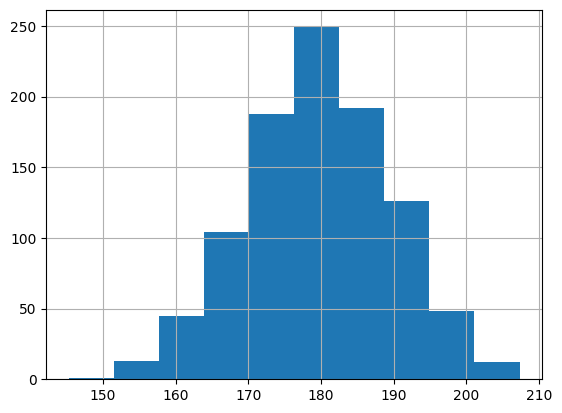

In [79]:
df_nonun["player_height"].hist()

In [80]:
df_nonun["player_height"].describe()

count    978.000000
mean     179.778696
std        9.894599
min      145.285701
25%      173.051278
50%      180.039480
75%      186.586257
max      207.308672
Name: player_height, dtype: float64

#### player weight

<Axes: >

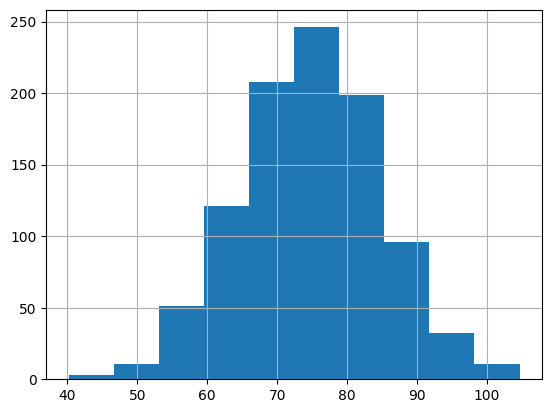

In [81]:
df_nonun["player_weight"].hist()

#### recovery time

<Axes: >

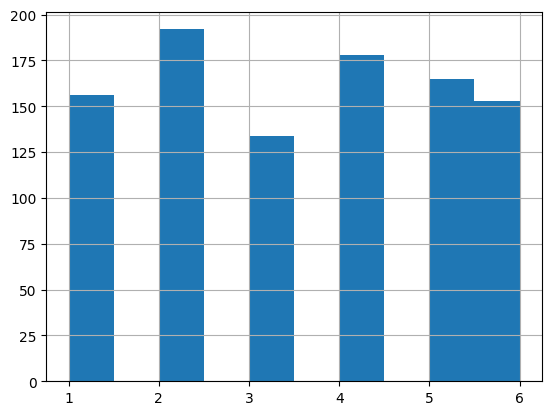

In [82]:
df_nonun["recovery_time"].hist()

In [83]:
df_nonun["recovery_time"].value_counts()

2    192
4    178
5    165
1    156
6    153
3    134
Name: recovery_time, dtype: int64

#### previous injures


<BarContainer object of 2 artists>

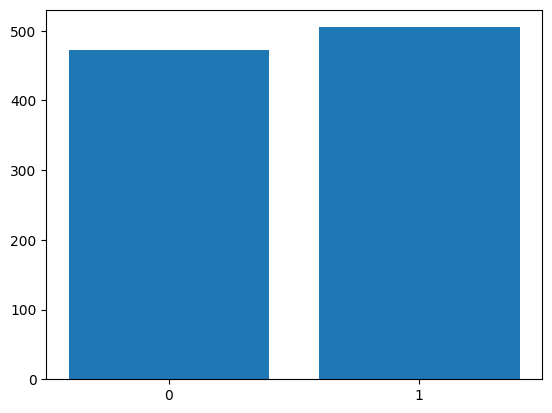

In [84]:
values, counts = np.unique(df_nonun["previous_injuries"], return_counts=True)
plt.bar(values, counts, tick_label=["0", "1"])

#### likelihood_of_injury

<BarContainer object of 2 artists>

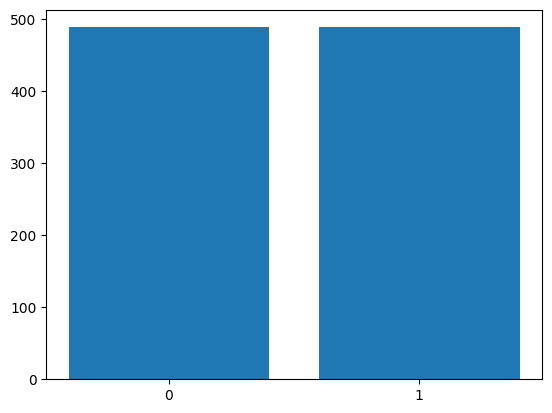

In [85]:
values, counts = np.unique(df_nonun["likelihood_of_injury"], return_counts=True)
plt.bar(values, counts, tick_label=["0", "1"])

In [86]:
df_nonun["likelihood_of_injury"].value_counts()

0.0    489
1.0    489
Name: likelihood_of_injury, dtype: int64

In [87]:
df_nonun

,index,player_age,player_weight,player_height,previous_injuries,training_intensity,recovery_time,likelihood_of_injury,flag_na_player_age,flag_na_previous_injuries,flag_dupli,player_id,flag_cu,categoria_allenamento
0,0,24.0,66.251933,175.732429,1.0,0.457929,5,0.0,False,False,False,player_id_0,False,medio_leggero
1,1,37.0,70.996271,174.581650,0.0,0.226522,6,1.0,False,False,False,player_id_1,False,leggero
2,2,32.0,80.093781,186.329618,0.0,0.613970,2,1.0,False,False,False,player_id_2,False,medio_duro
3,3,28.0,87.473271,175.504240,1.0,0.252858,4,1.0,False,False,False,player_id_3,False,medio_leggero
4,4,38.0,75.820549,206.631824,1.0,0.359209,4,0.0,False,False,False,player_id_4,False,medio_leggero
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,991,23.0,75.799934,178.132281,1.0,0.955448,1,0.0,False,False,False,player_id_991,False,duro
991,992,20.0,78.479061,173.823908,0.0,0.246961,1,1.0,False,False,False,player_id_992,False,leggero
992,993,24.0,66.915802,197.616889,1.0,0.859645,2,0.0,False,False,False,player_id_993,False,duro
993,994,36.0,71.847352,177.171535,0.0,0.168810,1,0.0,False,False,False,player_id_994,False,leggero


normalizzo le mie variabili

In [88]:
df_norm = df_nonun.copy().drop(["index","flag_na_player_age","flag_na_previous_injuries","flag_dupli","player_id","flag_cu","categoria_allenamento"],axis=1)

In [89]:
scaler = MinMaxScaler()
scaler.fit(df_norm)
scaled = scaler.fit_transform(df_norm)
df_norm = pd.DataFrame(scaled, columns=df_norm.columns)
df_norm

,player_age,player_weight,player_height,previous_injuries,training_intensity,recovery_time,likelihood_of_injury
0,0.285714,0.404293,0.490894,1.0,0.458945,0.8,0.0
1,0.904762,0.477897,0.472340,0.0,0.227009,1.0,1.0
2,0.666667,0.619035,0.661753,0.0,0.615343,0.2,1.0
3,0.476190,0.733520,0.487215,1.0,0.253406,0.6,1.0
4,0.952381,0.552740,0.989087,1.0,0.359999,0.6,0.0
...,...,...,...,...,...,...,...
973,0.238095,0.552420,0.529587,1.0,0.957602,0.0,0.0
974,0.095238,0.593984,0.460123,0.0,0.247495,0.0,1.0
975,0.285714,0.414593,0.843739,1.0,0.861580,0.2,0.0
976,0.857143,0.491100,0.514097,0.0,0.169165,0.0,0.0


In [90]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Assumiamo che df_norm sia il tuo DataFrame

# Preparazione dei dati
X = df_norm.drop("likelihood_of_injury", axis=1)  # Togli la variabile target
y = df_norm['likelihood_of_injury']  # La variabile target

# Divisione in set di addestramento e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalmente per gli alberi decisionali non è necessaria la normalizzazione, ma se hai normalizzato per altri modelli, assicurati di fare lo stesso qui per consistenza
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Addestramento del modello di albero decisionale
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train_scaled, y_train)

# Previsioni sul set di test
predictions = tree_model.predict(X_test_scaled)

# Valutazione del modello
print("Classification Report:")
print(classification_report(y_test, predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.56      0.53      0.55       105
         1.0       0.49      0.52      0.50        91

    accuracy                           0.53       196
   macro avg       0.52      0.52      0.52       196
weighted avg       0.53      0.53      0.53       196

Confusion Matrix:
[[56 49]
 [44 47]]


In [91]:
df_norm.corr()

,player_age,player_weight,player_height,previous_injuries,training_intensity,recovery_time,likelihood_of_injury
player_age,1.000000,-0.035496,0.050948,-0.057919,0.039604,-0.036804,0.005789
player_weight,-0.035496,1.000000,0.028054,0.037935,0.052828,-0.062246,-0.002566
player_height,0.050948,0.028054,1.000000,0.016682,0.047743,0.027241,0.032103
previous_injuries,-0.057919,0.037935,0.016682,1.000000,-0.024926,-0.010950,0.030691
training_intensity,0.039604,0.052828,0.047743,-0.024926,1.000000,-0.029434,0.092479
recovery_time,-0.036804,-0.062246,0.027241,-0.010950,-0.029434,1.000000,-0.013870
likelihood_of_injury,0.005789,-0.002566,0.032103,0.030691,0.092479,-0.013870,1.000000


In [113]:
def b(covarianza = float, varianzax = float):
    b = covarianza / varianzax
    return b

def a(mediay = float, b = float, mediax = float):
    a = mediay - (b*mediax)
    return a

In [117]:
b1 = b(0.005789,df_norm["player_age"].var())
a1 = a(df_norm["likelihood_of_injury"].mean(),b1,df_norm["player_age"].mean())
df_norm["likelihood_of_injury_predeto"] = a1 + b1*df_norm["player_age"]
df_norm["likelihood_of_injury_predeto_round"] = df_norm["likelihood_of_injury_predeto"].round(0)
df_norm

,player_age,player_weight,player_height,previous_injuries,training_intensity,recovery_time,likelihood_of_injury,likelihood_of_injury_predeto,likelihood_of_injury_predeto_round
0,0.285714,0.404293,0.490894,1.0,0.458945,0.8,0.0,0.488005,0.0
1,0.904762,0.477897,0.472340,0.0,0.227009,1.0,1.0,0.524975,1.0
2,0.666667,0.619035,0.661753,0.0,0.615343,0.2,1.0,0.510756,1.0
3,0.476190,0.733520,0.487215,1.0,0.253406,0.6,1.0,0.499381,0.0
4,0.952381,0.552740,0.989087,1.0,0.359999,0.6,0.0,0.527819,1.0
...,...,...,...,...,...,...,...,...,...
973,0.238095,0.552420,0.529587,1.0,0.957602,0.0,0.0,0.485161,0.0
974,0.095238,0.593984,0.460123,0.0,0.247495,0.0,1.0,0.476630,0.0
975,0.285714,0.414593,0.843739,1.0,0.861580,0.2,0.0,0.488005,0.0
976,0.857143,0.491100,0.514097,0.0,0.169165,0.0,0.0,0.522132,1.0


In [118]:
for idx, i in enumerate(df_norm["likelihood_of_injury_predeto_round"]):
    if i == df_norm["likelihood_of_injury"][idx]:
        df_norm["likelihood_of_injury_predeto_round"][idx] = True
    else:
        df_norm["likelihood_of_injury_predeto_round"][idx] = False

In [107]:
df_norm

,player_age,player_weight,player_height,previous_injuries,training_intensity,recovery_time,likelihood_of_injury,likelihood_of_injury_predeto,likelihood_of_injury_predeto_round
0,0.285714,0.404293,0.490894,1.0,0.458945,0.8,0.0,0.488005,True
1,0.904762,0.477897,0.472340,0.0,0.227009,1.0,1.0,0.524975,True
2,0.666667,0.619035,0.661753,0.0,0.615343,0.2,1.0,0.510756,True
3,0.476190,0.733520,0.487215,1.0,0.253406,0.6,1.0,0.499381,False
4,0.952381,0.552740,0.989087,1.0,0.359999,0.6,0.0,0.527819,False
...,...,...,...,...,...,...,...,...,...
973,0.238095,0.552420,0.529587,1.0,0.957602,0.0,0.0,0.485161,True
974,0.095238,0.593984,0.460123,0.0,0.247495,0.0,1.0,0.476630,False
975,0.285714,0.414593,0.843739,1.0,0.861580,0.2,0.0,0.488005,True
976,0.857143,0.491100,0.514097,0.0,0.169165,0.0,0.0,0.522132,False


In [119]:
df_norm["likelihood_of_injury_predeto_round"].value_counts()

True     510
False    468
Name: likelihood_of_injury_predeto_round, dtype: int64

In [120]:
df_nonun

,index,player_age,player_weight,player_height,previous_injuries,training_intensity,recovery_time,likelihood_of_injury,flag_na_player_age,flag_na_previous_injuries,flag_dupli,player_id,flag_cu,categoria_allenamento
0,0,24.0,66.251933,175.732429,1.0,0.457929,5,0.0,False,False,False,player_id_0,False,medio_leggero
1,1,37.0,70.996271,174.581650,0.0,0.226522,6,1.0,False,False,False,player_id_1,False,leggero
2,2,32.0,80.093781,186.329618,0.0,0.613970,2,1.0,False,False,False,player_id_2,False,medio_duro
3,3,28.0,87.473271,175.504240,1.0,0.252858,4,1.0,False,False,False,player_id_3,False,medio_leggero
4,4,38.0,75.820549,206.631824,1.0,0.359209,4,0.0,False,False,False,player_id_4,False,medio_leggero
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,991,23.0,75.799934,178.132281,1.0,0.955448,1,0.0,False,False,False,player_id_991,False,duro
991,992,20.0,78.479061,173.823908,0.0,0.246961,1,1.0,False,False,False,player_id_992,False,leggero
992,993,24.0,66.915802,197.616889,1.0,0.859645,2,0.0,False,False,False,player_id_993,False,duro
993,994,36.0,71.847352,177.171535,0.0,0.168810,1,0.0,False,False,False,player_id_994,False,leggero


In [129]:
df_nonun["bmi"] = df_nonun["player_weight"] / ((df_nonun["player_height"]/100)**2)

C:\Users\lucam\AppData\Local\Temp\ipykernel_20760\2001900054.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nonun["bmi"] = df_nonun["player_weight"] / ((df_nonun["player_height"]/100)**2)


In [130]:
df_nonun.drop(["flag_na_player_age","flag_na_previous_injuries","flag_dupli","flag_cu"],axis=1).corr()

C:\Users\lucam\AppData\Local\Temp\ipykernel_20760\694327063.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_nonun.drop(["flag_na_player_age","flag_na_previous_injuries","flag_dupli","flag_cu"],axis=1).corr()


,index,player_age,player_weight,player_height,previous_injuries,training_intensity,likelihood_of_injury,bmi
index,1.000000,0.000683,0.000525,-0.031496,-0.009394,0.011795,0.027479,0.017749
player_age,0.000683,1.000000,-0.035496,0.050948,-0.057919,0.039604,0.005789,-0.062208
player_weight,0.000525,-0.035496,1.000000,0.028054,0.037935,0.052828,-0.002566,0.756410
player_height,-0.031496,0.050948,0.028054,1.000000,0.016682,0.047743,0.032103,-0.622583
previous_injuries,-0.009394,-0.057919,0.037935,0.016682,1.000000,-0.024926,0.030691,0.018066
training_intensity,0.011795,0.039604,0.052828,0.047743,-0.024926,1.000000,0.092479,0.011733
likelihood_of_injury,0.027479,0.005789,-0.002566,0.032103,0.030691,0.092479,1.000000,-0.029788
bmi,0.017749,-0.062208,0.756410,-0.622583,0.018066,0.011733,-0.029788,1.000000


<Axes: >

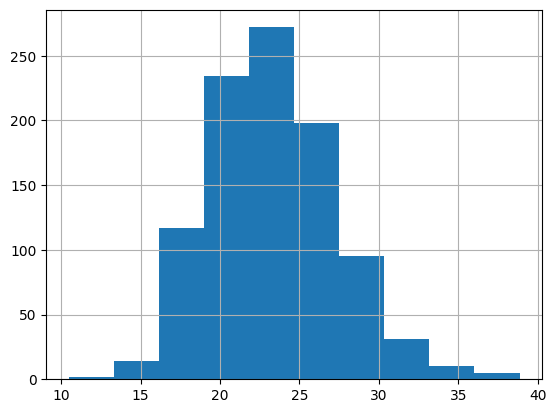

In [131]:
df_nonun["bmi"].hist()